## Run the script generate_report.py to find p-values and create a pdf that analyses the results.

In [10]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import os 
from scipy import stats
import seaborn as sns

### Read Test Outputs and calculate differences between Estimated and Chronological Age

In [2]:
def load_and_filter_data(measure, timeLimit, disease='stroke', disease1='stk', date=True):
    loaded = np.load(os.path.join('outputs', f'test_outputs_remaining_{measure}.npz'))
    predictions = loaded['predictions']
    ground_truths = loaded['ground_truths']
    subjects = loaded['subjects']
    labels = loaded['labels']
    sleep_stages = loaded['sleep_stages']

    subs = np.unique(subjects)
    cvd_summary = pd.read_csv(os.path.join('preprocess', 'shhs-cvd-summary-dataset-0.19.0.csv'))

    # Identify healthy and disease subjects
    healthy_at_baseline = cvd_summary[(cvd_summary['prev_mi'] == 0) &
                                        (cvd_summary['prev_stk'] == 0) &
                                        (cvd_summary['prev_chf'] == 0)]['nsrrid'].values

    healthy_after_baseline = cvd_summary[cvd_summary['nsrrid'].isin(healthy_at_baseline) &
                                            (cvd_summary['stroke'] == 0) &
                                            (cvd_summary['mi'] == 0) &
                                            (cvd_summary['chf'] == 0)]['nsrrid'].values

    if date:
        disease_after_baseline = cvd_summary[cvd_summary['nsrrid'].isin(healthy_at_baseline) &
                                                (cvd_summary[disease] > 0) &
                                                (cvd_summary[disease1 + '_date'] < timeLimit)]['nsrrid'].values
    else:
        disease_after_baseline = cvd_summary[cvd_summary['nsrrid'].isin(healthy_at_baseline) &
                                                (cvd_summary[disease] > 0)]['nsrrid'].values

    # Filter out irrelevant subjects
    not_av = [x for x in subs if x not in disease_after_baseline.tolist(
    ) + healthy_after_baseline.tolist()]
    remove_idx = [idx for x in not_av for idx in np.where(subjects == x)[
        0].tolist()]

    predictions = np.delete(predictions, remove_idx, axis=0)
    ground_truths = np.delete(ground_truths, remove_idx, axis=0)
    subjects = np.delete(subjects, remove_idx, axis=0)
    labels = np.delete(labels, remove_idx, axis=0)
    sleep_stages = np.delete(sleep_stages, remove_idx, axis=0)

    labels = np.array(
        [0 if x in healthy_after_baseline else 1 if x in disease_after_baseline else 2 for x in subjects])
    subs = np.unique(subjects)
    
    return predictions, ground_truths, subjects, labels, sleep_stages, subs

# Enhanced aesthetic settings
sns.set_theme(style="white", context="paper", font="Arial")

# Choose a pastel palette for a softer look
control_color = sns.color_palette("pastel")[0]  # Light Blue
patient_color = sns.color_palette("pastel")[2]  # Light Red
sns.set_palette([control_color, patient_color])

# Analysis parameters (unchanged)
time_windows = [3, 5, 10]
measures = ['both', 'ecg', 'eeg']
disease = 'stroke'
disease1 = 'stk'
date = True

plot_data = []
plot_groups = []
plot_times = []

for time in time_windows:
    timeLimit = 365 * time
    for measure in measures:
        
            
        predictions, ground_truths, subjects, labels, sleep_stages, subs = load_and_filter_data(measure, timeLimit)

        # Calculate differences
        differences = []
        outcomes = []
        # age_predition_stoke = []
        # age_prediction_healthy = []
        for sub in subs:
            sub_idx = np.where(subjects == sub)[0]
            differences.append(
                ground_truths[sub_idx].mean() - predictions[sub_idx].mean())
            outcomes.append(np.unique(labels[sub_idx])[0])

        
        differences = np.array(differences)
        outcomes = np.array(outcomes)

        ctrl_diffs = differences[outcomes == 0]
        pat_diffs = differences[outcomes == 1]

        if time == time_windows[0]:
            plot_data.extend(ctrl_diffs)
            plot_groups.extend(['Control'] * len(ctrl_diffs))
            plot_times.extend(['Baseline'] * len(ctrl_diffs))

        plot_data.extend(pat_diffs)
        plot_groups.extend(['Patient'] * len(pat_diffs))
        plot_times.extend([f'{time} Years'] * len(pat_diffs))

df_plot = pd.DataFrame({
    'Age Gap': plot_data,
    'Group': plot_groups,
    'Time Point': plot_times
})

df_plot['Time Point'] = df_plot['Time Point'].replace({'Baseline': 'Control'})
unique_times = ['Control', '3 Years', '5 Years', '10 Years']

# Function to add statistical annotations


def add_stat_annotation(ax, x_coords, y, text, line_offset=0.1, text_offset=0.05):
    x1, x2 = x_coords
    ax.plot([x1, x1, x2, x2], [y, y+line_offset, y +
            line_offset, y], color='black', linewidth=1.0)
    ax.text((x1+x2)*0.5, y+line_offset+text_offset, text,
            ha='center', va='bottom', fontsize=12, fontweight='bold')


order = unique_times
group_positions = {t: i for i, t in enumerate(order)}


## Box Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Control vs. 3 Years: p = 0.0002
Control vs. 5 Years: p = 0.0017
Control vs. 10 Years: p = 0.0490


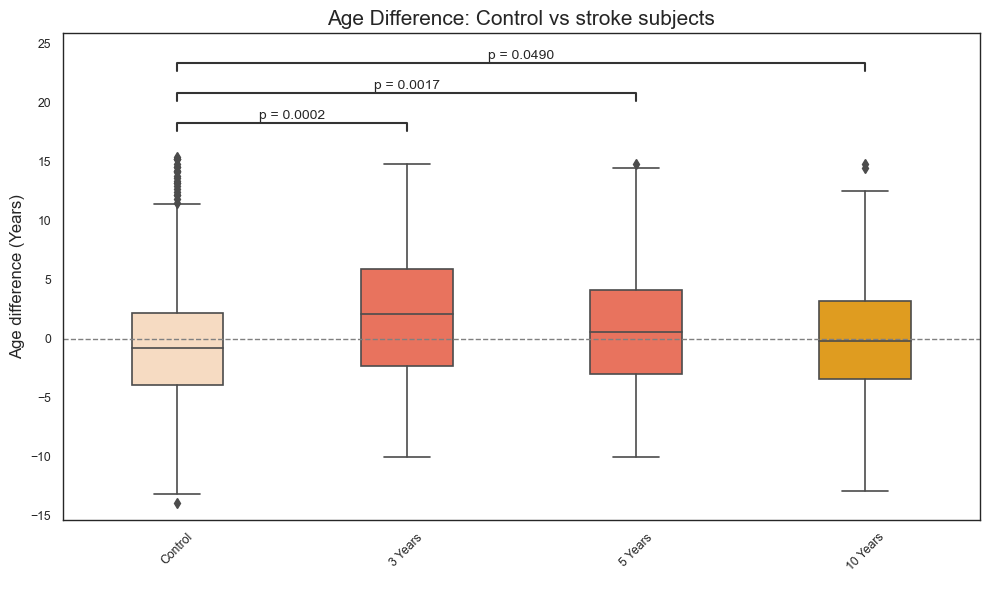

In [3]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

# Set matplotlib to display plots inline in Jupyter notebook
%matplotlib inline

def create_annotated_box_plot(df_plot):
    """
    Creates a box plot comparing age differences between control and stroke subjects over time,
    with statistical annotations showing p-values between groups.
    
    Args:
        df_plot (pd.DataFrame): DataFrame containing columns:
            - 'Time Point': Time points for comparison (Control, 3 Years, etc.)
            - 'Age Gap': Age difference values in years
    
    Returns:
        None: Displays the plot using plt.show()
    """
    # Validate input DataFrame columns
    columns = df_plot.columns.str.lower()
    time_point_col = [col for col in df_plot.columns if col.lower() == 'time point']
    age_gap_col = [col for col in df_plot.columns if col.lower() == 'age gap']
    
    if not time_point_col or not age_gap_col:
        raise ValueError(f"DataFrame must contain 'Time Point' and 'Age Gap' columns. " 
                        f"Current columns: {list(df_plot.columns)}")
    
    # Use first matching column names
    time_point_col = time_point_col[0]
    age_gap_col = age_gap_col[0]
    
    # Create figure with specified size
    plt.figure(figsize=(10, 6), dpi=100)
    
    # Get unique time points for ordering
    order = df_plot[time_point_col].unique().tolist()
    
    # Create box plot
    ax = sns.boxplot(x=time_point_col, y=age_gap_col, data=df_plot, 
                    order=order,
                    color=".8",
                    width=.4,
                    palette=["peachpuff",'tomato','tomato', 'orange'])
    
    # Customize plot appearance
    plt.title('Age Difference: Control vs stroke subjects', fontsize=15)
    plt.xlabel(' ', fontsize=0)
    plt.ylabel('Age difference (Years)', fontsize=12)
    plt.xticks(rotation=45)
    
    # Add horizontal reference line at y=0
    ax.axhline(0, color='grey', linestyle='--', linewidth=1)

    # Define pairs for statistical comparison
    pairs = [
        ('Control', '3 Years'),
        ('Control', '5 Years'),
        ('Control', '10 Years')
    ]
    
    # Add p-value annotations
    p_val_list = ['p = 0.0002','p = 0.0017','p = 0.0490']
    annotator = Annotator(ax, pairs, data=df_plot, x=time_point_col, y=age_gap_col, order=order)
    annotator.set_custom_annotations(p_val_list)
    annotator.annotate()
  
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Generate the annotated box plot
create_annotated_box_plot(df_plot)

### Hazard Ratio - Finding Risk of Stroke

In [4]:
# Set analysis parameters
measure = 'both'  # Which signals to analyze ('ecg', 'eeg', or 'both')
disease = 'stroke'  # Disease condition to analyze
disease1 = 'stk'  # Abbreviated disease name used in column names
timeLimit = 365*10  # Time limit in days (10 years)
date = True  # Whether to use date information for filtering

# Load and filter data using helper function
predictions, ground_truths, subjects, labels, sleep_stages, subs = load_and_filter_data(
    measure, timeLimit, disease, disease1, date)

# Load cardiovascular disease summary data
cvd_summary = pd.read_csv(os.path.join('preprocess', 'shhs-cvd-summary-dataset-0.19.0.csv'))

# Calculate per-subject metrics
difference = []  # Mean difference between true and predicted age
outcomes = []    # Disease outcome
time_to_event = []  # Time until disease onset
ages = []       # Subject ages
genders = []    # Subject genders

for sub in subs:
    sub_idx = np.where(subjects == sub)[0]
    difference.append(
        ground_truths[sub_idx].mean() - predictions[sub_idx].mean())
    outcomes.append(np.unique(labels[sub_idx])[0])
    time_to_event.append(cvd_summary[cvd_summary['nsrrid'] == sub]['stk_date'].fillna(0).values[0])
    ages.append(cvd_summary[cvd_summary['nsrrid'] == sub]['age_s1'].fillna(0).values[0])
    genders.append(cvd_summary[cvd_summary['nsrrid'] == sub]['gender'].fillna(0).values[0])

# Convert lists to numpy arrays for further analysis
difference = np.array(difference)
outcomes = np.array(outcomes)


In [5]:
survival_df = pd.DataFrame({
    'duration': time_to_event,
    'event': outcomes == 1, 
    'age_difference': difference,
    'age': ages,
    'gender': genders
})

survival_df = survival_df[survival_df['duration'] > 0]

median_diff = np.median(survival_df['age_difference'])
survival_df['high_difference'] = survival_df['age_difference'] > 0

from lifelines import KaplanMeierFitter, CoxPHFitter

# Fit Cox proportional hazards model for all data
cph = CoxPHFitter()
cph.fit(survival_df[['duration', 'event', 'age_difference', 'age', 'gender']], 
        duration_col='duration', 
        event_col='event')

print("\nCox Proportional Hazards Model Summary (All Data):")
print(cph.print_summary())



Cox Proportional Hazards Model Summary (All Data):


<lifelines.CoxPHFitter: fitted with 108 total observations, 0 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 108
number of events observed = 108
   partial log-likelihood = -392.64
         time fit was run = 2024-12-17 12:04:01 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
age_difference   0.21       1.24       0.07             0.07             0.35                 1.08                 1.42
age             -0.15       0.86       0.07            -0.29            -0.00                 0.75                 1.00
gender           0.08       1.08       0.22            -0.36             0.52                 0.70                 1.67

                 cmp to     z      p   -log2(p)
covariate                                      
age_difference     0.00  3.00 <0.005       8.53
age                0.00 -1.99   0.05       4.41
gender             0.00  0.36   0.72       0.48
---
Concordance = 0.61
Partial AIC = 791.28
log-likelihood ratio test = 16.58 on 3 df
-log2(p) of ll-ratio test = 10.18

None


## Model Training

It should be noted that we dont not expect perfect age estimation. The risk of stroke is predicted based on the errors, so we expect meaningfull deviations in estimated age depending on the health of the patient.


In [6]:
def plot(training_data, title):
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')  # Use seaborn style for better aesthetics

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(title, fontsize=16, y=1.05)

    # Plot losses
    ax1.plot(training_data['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(training_data['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Loss', pad=10)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(frameon=True)
    ax1.grid(True, alpha=0.3)

    # Plot MSE
    ax2.plot(training_data['train_mse'], label='Train MSE', linewidth=2)
    ax2.plot(training_data['val_mse'], label='Validation MSE', linewidth=2)
    ax2.set_title('Mean Squared Error', pad=10)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MSE')
    ax2.legend(frameon=True)
    ax2.grid(True, alpha=0.3)

    # Plot MAE 
    ax3.plot(training_data['train_mae'], label='Train MAE', linewidth=2)
    ax3.plot(training_data['val_mae'], label='Validation MAE', linewidth=2)
    ax3.set_title('Mean Absolute Error', pad=10)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MAE')
    ax3.legend(frameon=True)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

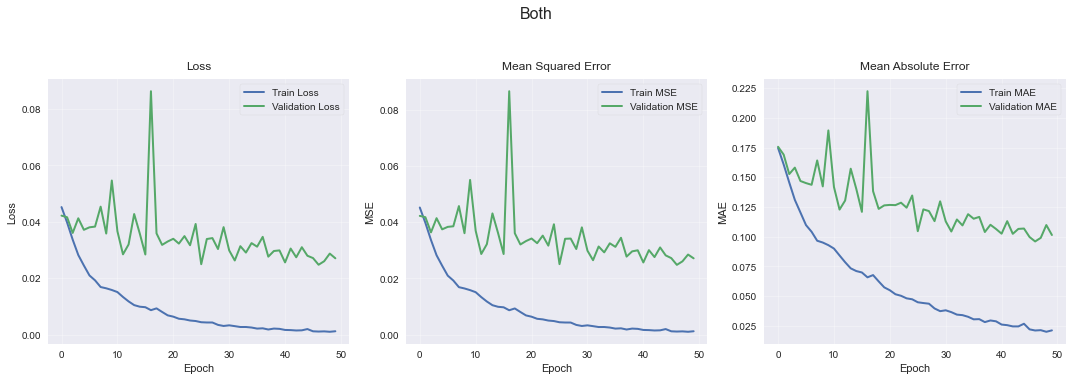

In [7]:
# Load training data
with open(os.path.join('checkpoints', 'training_history', 'training_history_both.json'), 'r') as f:
    training_data = json.load(f)

plot(training_data, 'Both')


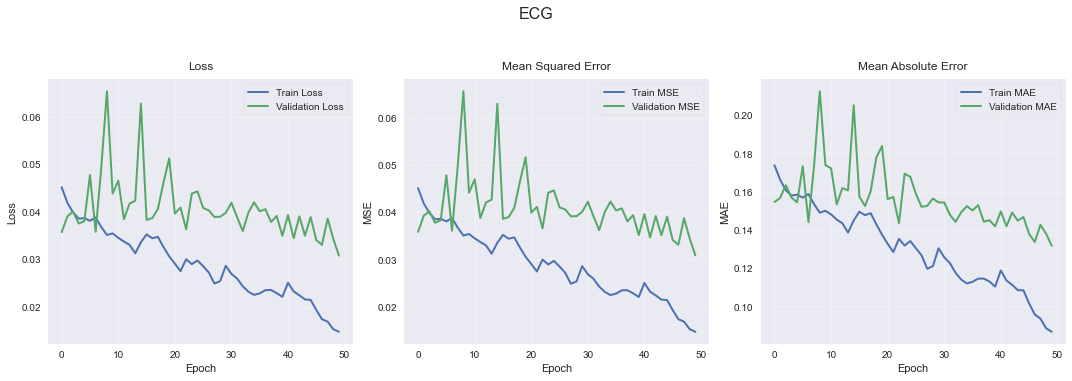

In [8]:
# Load training data
with open(os.path.join('checkpoints', 'training_history', 'training_history_ecg.json'), 'r') as f:
    training_data = json.load(f)

plot(training_data, 'ECG')


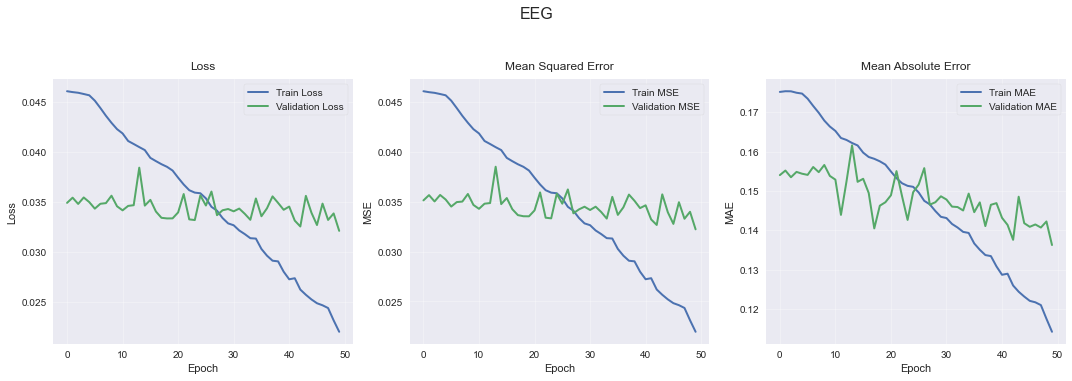

In [9]:
# Load training data
with open(os.path.join('checkpoints', 'training_history', 'training_history_eeg.json'), 'r') as f:
    training_data = json.load(f)

plot(training_data, 'EEG')
